Import Libraries

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

Defining group members and image labels

In [35]:
group_members = ['Branis', 'Tanguy', 'Nelly', 'Nhial']
image_labels = ['neutral', 'smiling', 'surprised']
input_dir = 'images'
augmented_dir = 'augmented_images'
os.makedirs(augmented_dir, exist_ok=True)

Load & Display Sample Images


Showing images for: Branis


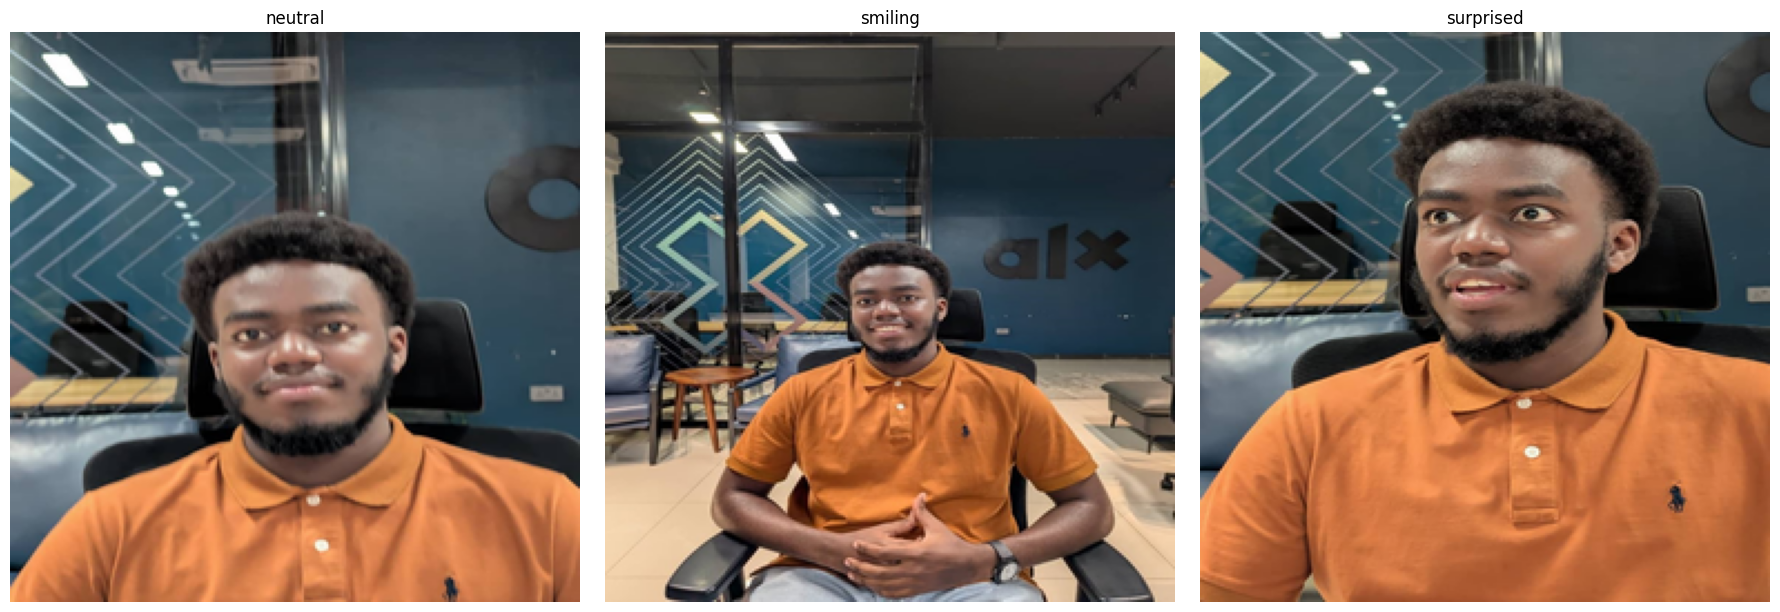

Showing images for: Tanguy


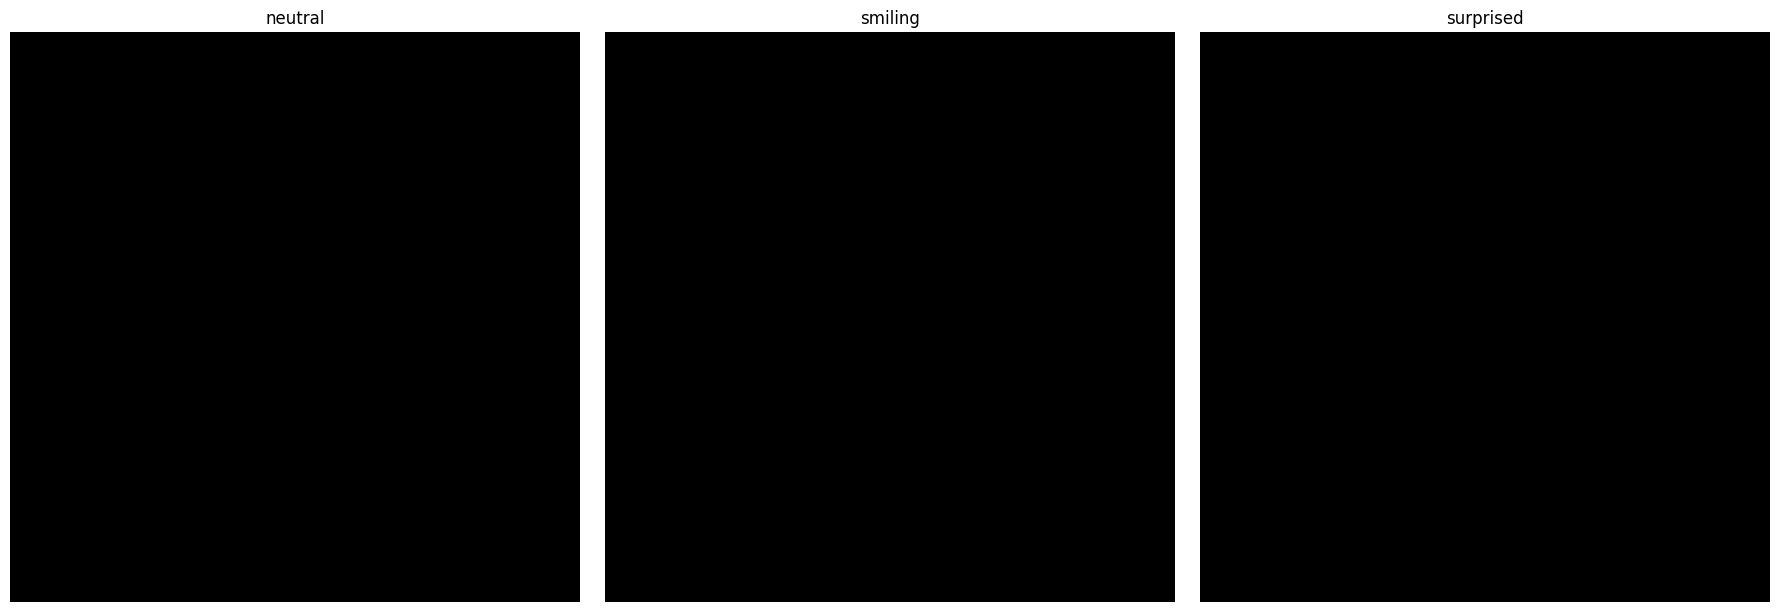

Showing images for: Nelly


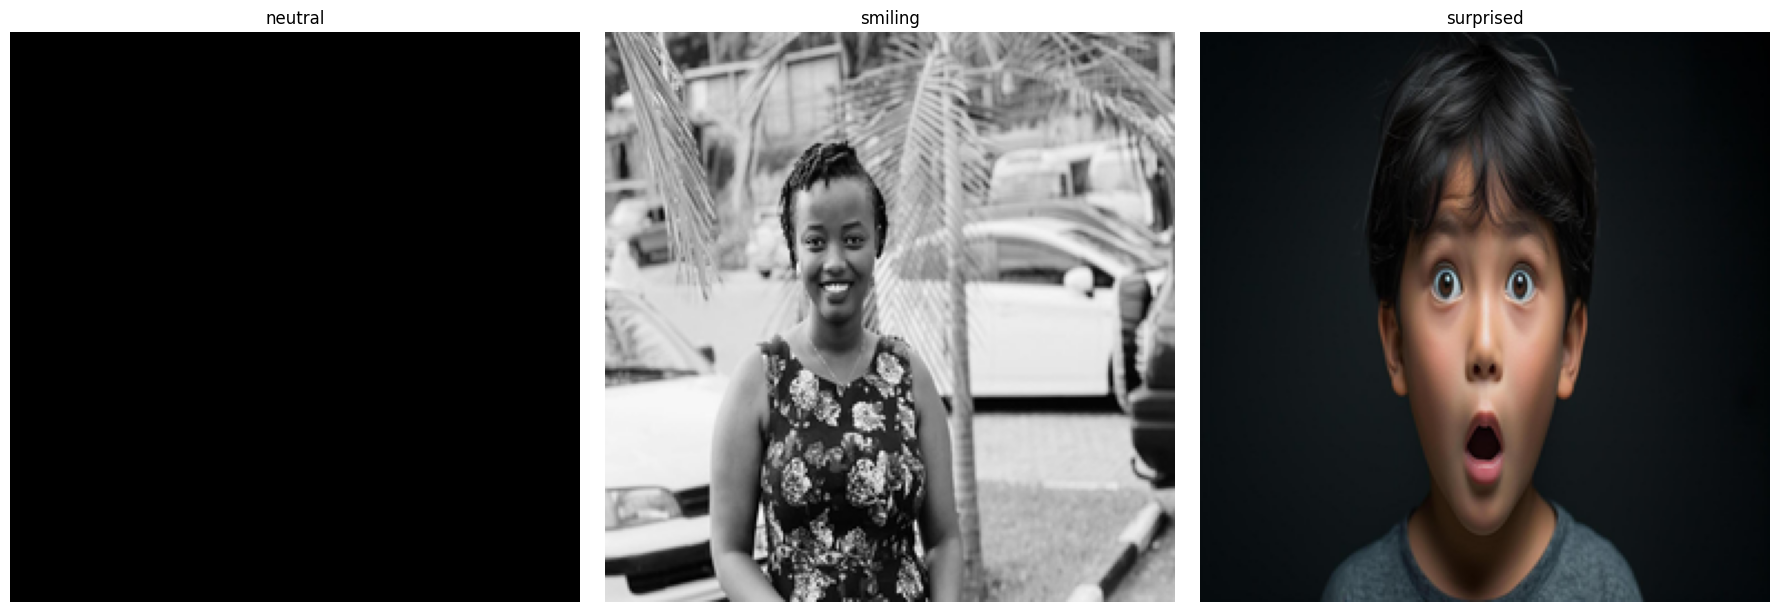

Showing images for: Nhial


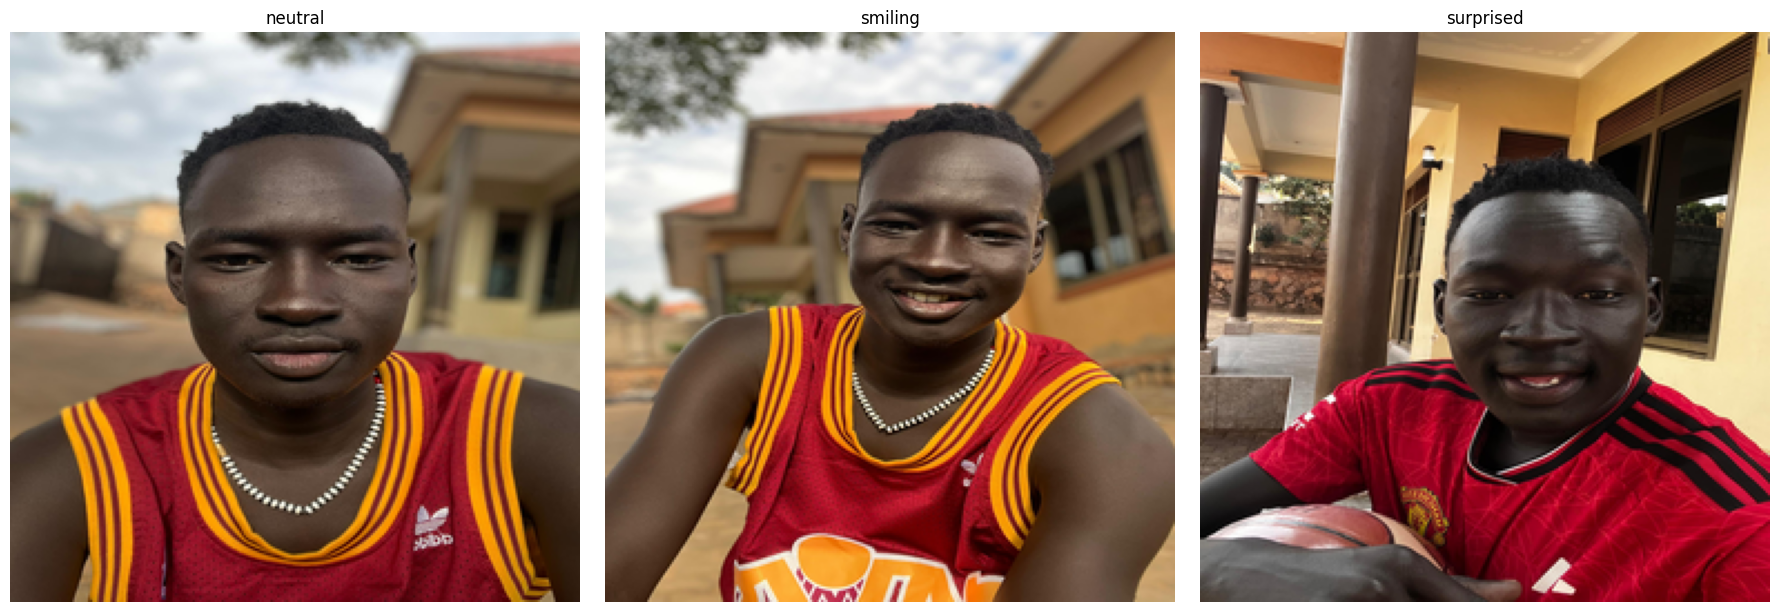

In [36]:


all_images = {}

for member in group_members:
    member_dir = os.path.join(input_dir, member)
    member_images = {}
    
    for label in image_labels:
        img_path = os.path.join(member_dir, f'{label}.jpg')
        if os.path.exists(img_path):
            img = Image.open(img_path)
            # Use LANCZOS filter for sharp resizing
            img = img.resize((256, 256), Image.LANCZOS)
            member_images[label] = img
            
    all_images[member] = member_images

for member in all_images:
    print(f"Showing images for: {member}")
    fig, axs = plt.subplots(1, len(image_labels), figsize=(18, 6))
    for i, label in enumerate(image_labels):
        img = all_images[member].get(label, Image.new('RGB', (256, 256)))
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


Augmentation function

In [37]:
def augment_image(image):
    return {
        'rotated': image.rotate(30),
        'flipped': ImageOps.mirror(image),
        'grayscale': ImageOps.grayscale(image).convert('RGB')
    }

augmented_images = {}

for member, imgs in all_images.items():
    member_augmented = {}
    for label, img in imgs.items():
        augmented_versions = augment_image(img)
        for aug_type, aug_img in augmented_versions.items():
            member_augmented[f'{label}_{aug_type}'] = aug_img
    augmented_images[member] = member_augmented


NameError: name 'ImageOps' is not defined

Applying augmentations to all images

In [ ]:

def augment_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    flipped = cv2.flip(image, 1)
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    return {
        'original': image,
        'grayscale': gray,
        'flipped': flipped,
        'rotated': rotated
    }


Histogram extraction

In [ ]:
def extract_color_histogram(image_path, bins=96):
    try:
        image = Image.open(image_path).convert("RGB")
        histogram = image.histogram()
        histogram = np.array(histogram).astype('float32')
        histogram /= histogram.sum()  # Normalize
        return histogram
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

Feature Extraction (Using Histograms)

In [ ]:
def extract_histogram(image):
    image_np = np.array(image)
    hist_r, _ = np.histogram(image_np[:, :, 0], bins=16, range=(0, 256))
    hist_g, _ = np.histogram(image_np[:, :, 1], bins=16, range=(0, 256))
    hist_b, _ = np.histogram(image_np[:, :, 2], bins=16, range=(0, 256))
    return np.concatenate([hist_r, hist_g, hist_b])


 Extract and Save Features

In [ ]:
feature_rows = []

for member in group_members:
    # Original images
    for label, img in all_images.get(member, {}).items():
        hist = extract_histogram(img)
        feature_rows.append({
            'member': member,
            'image_type': label,
            **{f'bin_{i}': val for i, val in enumerate(hist)}
        })

    # Augmented images
    for label_aug, img in augmented_images.get(member, {}).items():
        hist = extract_histogram(img)
        feature_rows.append({
            'member': member,
            'image_type': label_aug,
            **{f'bin_{i}': val for i, val in enumerate(hist)}
        })

features_df = pd.DataFrame(feature_rows)
features_df.to_csv('image_features.csv', index=False)
print(f"Extracted features for {features_df.shape[0]} images and saved to 'image_features.csv'")
features_df.head()


Extracted features for 32 images and saved to 'image_features.csv'


,member,image_type,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,...,bin_38,bin_39,bin_40,bin_41,bin_42,bin_43,bin_44,bin_45,bin_46,bin_47
0,Branis,neutral,2462,3339,7379,11832,7560,5986,2669,2026,...,12841,6131,2680,1312,887,657,301,135,29,260
1,Branis,smiling,1032,8727,10143,8120,5434,3472,2833,2871,...,4175,3622,2588,2808,4257,792,445,90,31,130
2,Branis,surprised,3177,3580,5990,7811,5022,2172,2263,1975,...,6896,2629,1789,1041,616,425,165,55,20,57
3,Branis,neutral_rotated,12601,3150,6126,9731,6657,5461,2288,1827,...,11750,5286,2268,1162,720,596,249,118,24,113
4,Branis,neutral_flipped,2462,3339,7379,11832,7560,5986,2669,2026,...,12841,6131,2680,1312,887,657,301,135,29,260
